In [1]:
import numpy as np
import pandas as pd

from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans

import wrangle as wr
import preprocessing as pr
import explore as ex
import model as mo

import warnings
warnings.filterwarnings("ignore")


Bad key "text.kerning_factor" on line 4 in
/usr/local/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
pd.set_option("display.max_columns", None)
# pd.set_option('display.float_format', lambda x: '%.5f' % x)
plt.rc("figure", figsize=(16, 8))

In [3]:
df = wr.wrangle_hud()
print(df.shape)
df.head()

(20409, 31)


,fha_number,project_name,project_city,project_state,basic_fha_risk_share_or_other,program_category,activity_description,activity_group,facility_type,program_designation,firm_commitment_activity,lender_at_firm_commitment_activity,mortgage_at_time_of_firm_commitment_issuance_amendment_or_reissuance,unit_or_bed_count,date_of_firm_commitment_activity,fiscal_year_of_firm_commitment_activity,mortgage_at_firm_commitment_issuance,date_of_firm_issue,fiscal_year_of_firm_commitment,map_or_tap,lihtc_designation,tax_exempt_bond_designation,home_designation,cdbg_designation,section_202_refi_designation,irp_decoupling_designation,hope_vi_designation,current_status,final_mortgage_amount,is_refinance,is_new_construction
0,11345004,Western Heights Apartments,Olney,TX,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/236,Firm Issued,GREYSTONE SERVICING COMPANY LLC,277600,48,2005-10-01,2006,277600,2005-10-01,2006,TAP,False,False,False,False,False,False,False,Firm Comit then Owner Withdrew,271700,True,False
1,11345005,Woodlands Village Apts,Breckenridge,TX,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/236,Firm Issued,GREYSTONE SERVICING COMPANY LLC,173000,88,2005-10-01,2006,173000,2005-10-01,2006,TAP,False,False,False,False,False,False,False,Finally Endorsed,168300,True,False
2,4235583,Harbor Court Apartments,Rocky River,OH,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/221d4,Firm Issued,GREYSTONE SERVICING COMPANY LLC,3886800,120,2005-10-03,2006,3886800,2005-10-03,2006,TAP,False,False,False,False,False,False,False,Finally Endorsed,3886800,True,False
3,3297260,Compton Towne Apartments,Wilmington,DE,Risk Sharing,QPE Risk Sharing,Refinance,Refi/ Pchse,Coop/Apts/Mobile Home Pk/ALF,QPE Risk Shg Existing,Firm Issued,FEDERAL NATIONAL MORTGAGE,4000000,76,2005-10-03,2006,4000000,2005-10-03,2006,TAP,True,False,False,False,False,False,False,Finally Endorsed,4000000,True,False
4,7135779,Evergreen Terrace I,Joliet,IL,Basic FHA,223a7 Refi Apts,Refinance,Refi/ Pchse,Apts,a7/221d4,Firm Issued,REILLY MORTGAGE GRP,5129000,241,2005-10-04,2006,5129000,2005-10-04,2006,TAP,False,False,False,False,False,False,False,Firm Expired,5247700,True,False


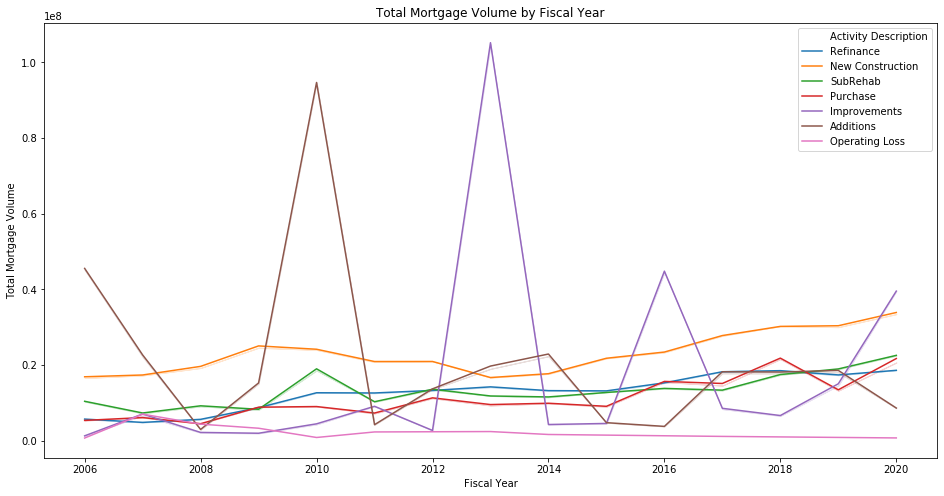

In [4]:
city_state_all_activity = pd.DataFrame(
    df.groupby(
        [
            "project_city",
            "project_state",
            "fiscal_year_of_firm_commitment_activity",
            "activity_description",
        ]
    )["final_mortgage_amount"]
    .agg(["count", "sum"])
    .reset_index()
    .sort_values(by=["count", "sum"], ascending=False)
)

fig, ax = plt.subplots()

sns.lineplot(
    data=city_state_all_activity,
    x="fiscal_year_of_firm_commitment_activity",
    y="sum",
    hue="activity_description",
    ci=False,
    ax=ax,
)

legend = ax.legend()
legend.texts[0].set_text("Activity Description")

plt.xlabel("Fiscal Year")
plt.ylabel("Total Mortgage Volume")
plt.title("Total Mortgage Volume by Fiscal Year")
plt.show()

**Takeaway**: New Construction (NC) mortgages have been growing steadily since 2014. Overall, NC is consistently where most of the mortgage loan volume is being allocated. *If we can find cities that are spending a lot on NC, we can ID those as markets to enter.*

### Hypothesis Testing

$H_0$: The mean final mortgage amount is the same across all activity descriptions

$H_a$: The mean final mortgage amount is different depending on the activity description

In [5]:
df.activity_description.unique().tolist()

['Refinance',
 'SubRehab',
 'New Construction',
 'Purchase',
 'Additions',
 'Improvements',
 'Operating Loss']

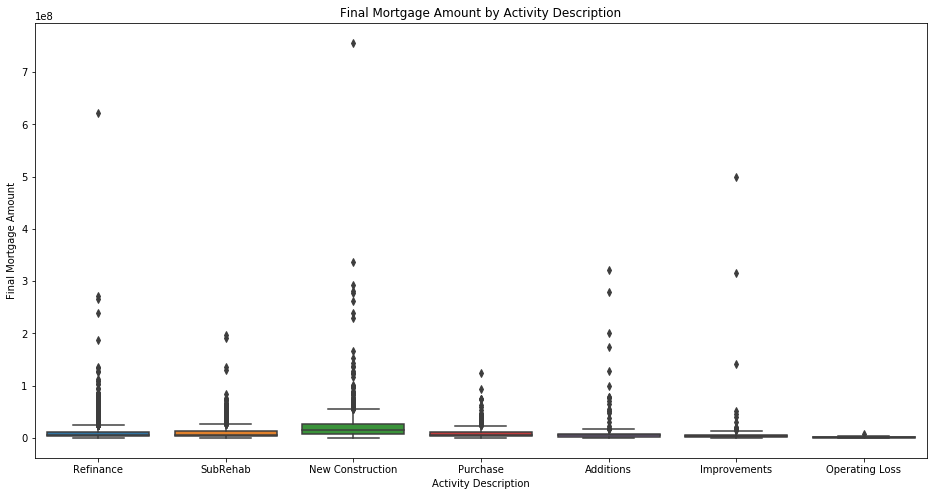

In [6]:
plt.figure(figsize=(16, 8))

sns.boxplot(data=df, x="activity_description", y="final_mortgage_amount")
plt.title("Final Mortgage Amount by Activity Description")
plt.xlabel("Activity Description")
plt.ylabel("Final Mortgage Amount")
plt.show()

In [7]:
# def plot_mortgage_vol_by_year():
#     city_state_all_activity = pd.DataFrame(
#         df.groupby(
#             [
#                 "project_city",
#                 "project_state",
#                 "fiscal_year_of_firm_commitment_activity",
#                 "activity_description",
#             ]
#         )["final_mortgage_amount"]
#         .agg(["count", "sum"])
#         .reset_index()
#         .sort_values(by=["count", "sum"], ascending=False)
#     )

#     fig, ax = plt.subplots()

#     sns.lineplot(
#         data=city_state_all_activity,
#         x="fiscal_year_of_firm_commitment_activity",
#         y="sum",
#         hue="activity_description",
#         ci=False,
#         ax=ax,
#     )

#     legend = ax.legend()
#     legend.texts[0].set_text("Activity Description")

#     plt.xlabel("Fiscal Year")
#     plt.ylabel("Total Mortgage Volume")
#     plt.title("Total Mortgage Volume by Fiscal Year")
#     plt.show()

In [8]:
# plot_mortgage_vol_by_year()

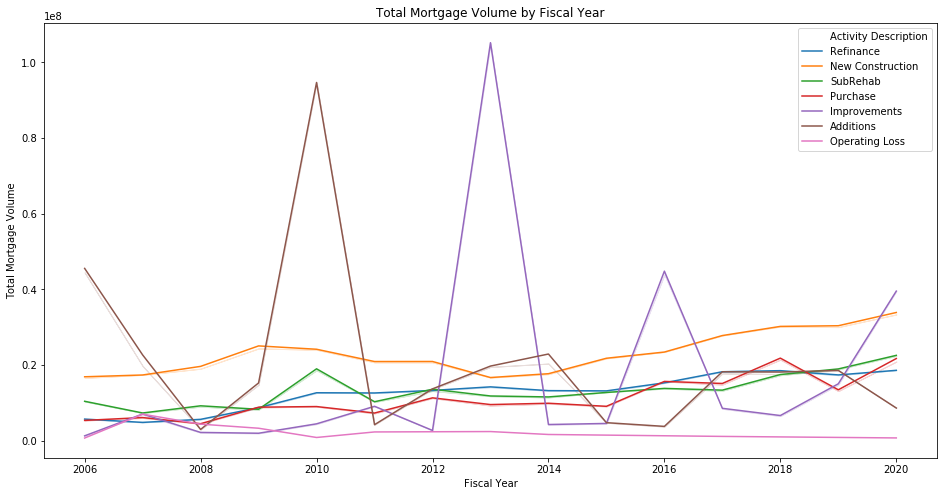

In [9]:
ex.plot_mortgage_vol_by_year(df)

## Preprocessing

In order to get our data into a useable format for molding we decided to group the data by a city and state for each year to get unique observations.